<a href="https://colab.research.google.com/github/benson0714/DRL/blob/main/HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install -y xvfb


!pip install gym==0.21 gym[box2d] pytorch-lightning==1.6.0 pyvirtualdisplay
# !pip install https://github.com/PyTorchLightning/pytorch-lightning/archive/refs/heads/release/1.5.x.zip

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  xvfb
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 784 kB of archives.
After this operation, 2,271 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.10 [784 kB]
Fetched 784 kB in 1s (1,471 kB/s)
Selecting previously unselected package xvfb.
(Reading database ... 155632 files and directories currently installed.)
Preparing to unpack .../xvfb_2%3a1.19.6-1ubuntu4.10_amd64.deb ...
Unpacking xvfb (2:1.19.6-1ubuntu4.10) ...
Setting up xvfb (2:1.19.6-1ubuntu4.10) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheel

In [2]:
from pyvirtualdisplay import Display
Display(visible=False, size=(1400, 900)).start()

In [3]:
import copy
import gym
import torch
import random

import numpy as np
import torch.nn.functional as F

from collections import deque, namedtuple
from IPython.display import HTML
from base64 import b64encode

from torch import Tensor, nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset
from torch.optim import AdamW

from pytorch_lightning import LightningModule,Trainer

from gym.wrappers import RecordVideo, RecordEpisodeStatistics, TimeLimit

from pytorch_lightning.callbacks import EarlyStopping




device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
num_gpus = torch.cuda.device_count()

In [4]:
def display_video(episode=0):
  video_file = open(f'/content/videos/rl-video-episode-{episode}.mp4', "r+b").read()
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"<video width=600 controls><source src='{video_url}'></video>")

In [5]:
class DQN(nn.Module):
  
  def __init__(self, hidden_size, obs_size, n_actions):
    super().__init__()
    self.net=nn.Sequential(
        nn.Linear(obs_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ReLU(),
        nn.Linear(hidden_size, n_actions)
    )

  def forward(self, x):
    return self.net(x.float())  

In [6]:
def epsilon_greedy(state, env, net, epsilon=0.0):
  if np.random.random() < epsilon:
    action = env.action_space.sample()
  else:
    state = torch.tensor([state]).to(device)
    q_values = net(state)
    _, action =torch.max(q_values, dim=1)
    action = int(action.item())
  return action

In [7]:
class ReplayBuffer:

  def __init__(self, capacity):
    self.buffer= deque(maxlen=capacity)
  
  def __len__(self):
    return len(self.buffer)

  def append(self, experience):
    self.buffer.append(experience) 

  def sample(self,batch_size):
    return random.sample(self.buffer,batch_size) 


In [8]:
class RLDataset(IterableDataset):

  def __init__(self, buffer, sample_size=200):
     self.buffer = buffer
     self.sample_size = sample_size
    
  def __iter__(self):
    for experience in self.buffer.sample(self.sample_size):
      yield experience

In [9]:
def create_environment(name):
  env=gym.make(name)
  env=TimeLimit(env, max_episode_steps=400)
  record_interval=100
  env=RecordVideo(env, video_folder='./videos',episode_trigger=lambda x: x% record_interval==0)
  env=RecordEpisodeStatistics(env)
  return env

/usr/local/lib/python3.7/dist-packages/gym/wrappers/record_video.py:42: UserWarning: WARN: Overwriting existing videos at /content/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  f"Overwriting existing videos at {self.video_folder} folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)"


action_space_n= 24


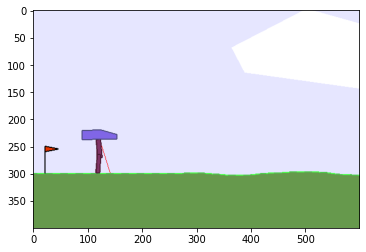

In [14]:
env=create_environment('BipedalWalker-v3')
env.reset()
#testing
env.observation_space.sample()
env.action_space.sample()
# env.observation_space.shape[0]替代env.action_space.n
print("action_space_n=",env.observation_space.shape[0])

import matplotlib.pyplot as plt
plt.imshow(env.render(mode='rgb_array'))
